In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from FKMC.general import shapes

%matplotlib inline
np.seterr(all='warn')
mpl.rcParams['figure.dpi'] = 70

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

from functools import wraps
if not hasattr(plt, 'old_subplots'): plt.old_subplots = plt.subplots
@wraps(plt.old_subplots)
def my_subplots(*args, **kwargs):
    if not 'figsize' in kwargs and len(args) > 1:
        width = 5
        maxwidth = 15
        rows, cols, *_ = args
        w = min(maxwidth, width * cols)
        kwargs['figsize'] = (w, w / cols / 1.6 * rows)
    
    gridspec_kw = dict()
    if kwargs.get('sharex') == 'col':
        gridspec_kw['hspace'] = 0.1
    if kwargs.get('sharey') == 'row':
        gridspec_kw['wspace'] = 0.1
    if 'gridspec_kw' in kwargs:
        gridspec_kw.update(kwargs['gridspec_kw'])
    kwargs['gridspec_kw'] = gridspec_kw
    
    return plt.old_subplots(*args, **kwargs)
        
plt.subplots = my_subplots

In [31]:
from import_funcs import get_data_structured
from pathlib import Path

obs = get_data_structured(Path('/data/users/tch14/slurm_runs/97469'),
                requested_observables = ['Ff', 'Fc', 'Mf_moments', 'time', 'IPRs', 'eigenvals', 'state','accept_rates', 'classical_accept_rates', 'proposal_rates'],
               structure_names = ('repeats',),
               structure_dims = (100,),
               )

looking in /data/users/tch14/slurm_runs/97469
job ids range from 0 to 99
structure_names = ('repeats',)
structure_dims = (100,)
Expected number of jobs 100
Missing jobs: {82, 12, 98, 92}

Logger keys:  ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

MCMC_params:  {'state': '...', 'N_steps': 1000000, 'N_burn_in': 10000, 'thin': 1000, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7fc2a5accbe0>, 'proposal': <function p_multi_site_uniform_reflect at 0x7fc2e71cb2f0>, 'accept_function': <function perturbation_accept at 0x7fc2e71cb620>, 'warnings': True} 

MCMC Steps: 1000000 with thinning = 1000 for 1000 recorded steps
Slicing this with MCMC_slice = slice(None, None, 1)

[(0, 'repeats', 100)]
available observables = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update']

In [4]:
obs.state[0].shape, obs.state_shapehint

((100, 1000, 4), ('Ns', 'repeats', 'MCstep', 'N'))

In [32]:
#save the real data in a useful form
real_data = dict()
real_data_states = dict()
for s in obs.state:
    #remove the parts of the dataset that contain nans
    i = np.all(np.isfinite(s), axis = (-2,-1))
    states = s[i, ...]
    
    AFM_spins = 2*states - 1 #convert to spin representation

    N = AFM_spins.shape[-1]
    alternating = 2*(np.arange(N) % 2) - 1
    FM_spins = AFM_spins * alternating

    #calculate the 2d correlation matrix
    #C = np.cov(FM_spins, rowvar = False)

    #calculate the 1d correlation function
    #corr_func = diag2column(C).mean(axis = 0)
    #dcorr_func = diag2column(C).std(axis = 0)
    
    real_data_states[N] = states.reshape(-1, states.shape[-1])
    real_data[N] = FM_spins.reshape(-1, FM_spins.shape[-1])

0.009979166666666667 1.0


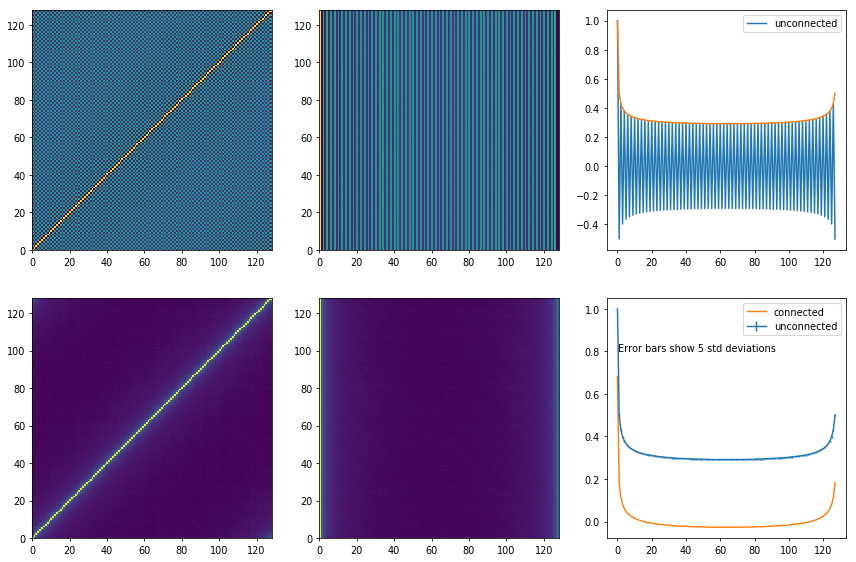

In [33]:
from FKMC.general import diag2column, spread
N  = 128
#using the AFM ordered spins
C = np.cov(2*real_data_states[N] - 1, rowvar = False)
corr_func = diag2column(C).mean(axis = 0)

#using the FM ordered spins
C2 = np.cov(real_data[N], rowvar = False)

state_means = real_data[N].mean(axis=-1)[:, None]
connected_C2 = np.cov(real_data[N] - state_means, rowvar = False)
connected_corr_func2 = diag2column(connected_C2).mean(axis = 0)

corr_func2 = diag2column(C2).mean(axis = 0)
dcorr_func2 = diag2column(C2).std(axis = 0)

f, axes = plt.subplots(2,3, figsize = (15,10))   

axes[0,0].pcolormesh(C.T)
axes[0,1].pcolormesh(diag2column(C))
axes[0,2].plot(corr_func, label = 'unconnected')
axes[0,2].legend()

axes[1,0].pcolormesh(C2.T)
axes[1,1].pcolormesh(diag2column(C2))

axes[0,2].plot(corr_func2)

axes[1,2].errorbar(range(corr_func2.shape[-1]), corr_func2, dcorr_func2, label = 'unconnected')
axes[1,2].text(0.4,0.8,'Error bars show 5 std deviations')

axes[1,2].plot(connected_corr_func2, label = 'connected')
axes[1,2].legend()

    
print(max(abs(means)), max((ameans)))

## Candidate fit functions

(100,)


[None, None]

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/ma/core.py:856: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


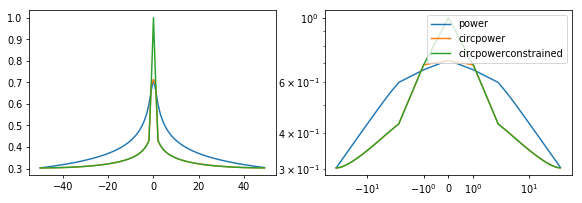

In [34]:
N = 100

def power(x, A, gamma): return A*(1+x**2)**(-gamma/2)
def powerplusconst(x, A, gamma, B): return power(x, A, gamma) + B
def powerconst_contrained(x, A, gamma, B): 
    return np.where(x == 0, 1, power(x, A, gamma) + B)
def exponential(x, A, B, l): return A*np.exp(-np.abs(x)/l)+B
def circpower(N): 
    def f(x, A, gamma):
        y = abs(x)
        return power(y, A/2, gamma) + power(np.where(y > 1, (N-y), 0), A/2, gamma)
    return f
def best(N): 
    def f(x, A, gamma, B):
        return np.where(np.abs(x) < 1, 1, circpower(N)(x, A, gamma) + B)
    return f

sym = np.arange(-N//2, N//2)
print(sym.shape)
f,axes = plt.subplots(1,2)
A, gamma = 0.71315506, 0.21858357

for ax in axes:
    ax.plot(sym, power(sym, A, gamma), label = 'power')
    ax.plot(sym, circpower(N)(sym, A, gamma), label = 'circpower')
    ax.plot(sym, best(N)(sym, A, gamma, 0), label = 'circpowerconstrained')

ax.legend()
ax.set(xscale = 'symlog', yscale = 'log')

## Fit them to the data

corr_func[0] = 0.9999998937977218
exponential, popt = [0.15194656 0.29438763 7.70707743] +/- [0.00232902 0.00036724 0.15909992]
power plus const constrained, popt = [0.28414721 0.68816292 0.27362544] +/- [0.00232501 0.01235266 0.00109601]
circplusconst, popt = [ 1.62132471  0.040336   -1.07733435] +/- [1.87210352 0.05099471 1.87383756]


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/ma/core.py:856: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


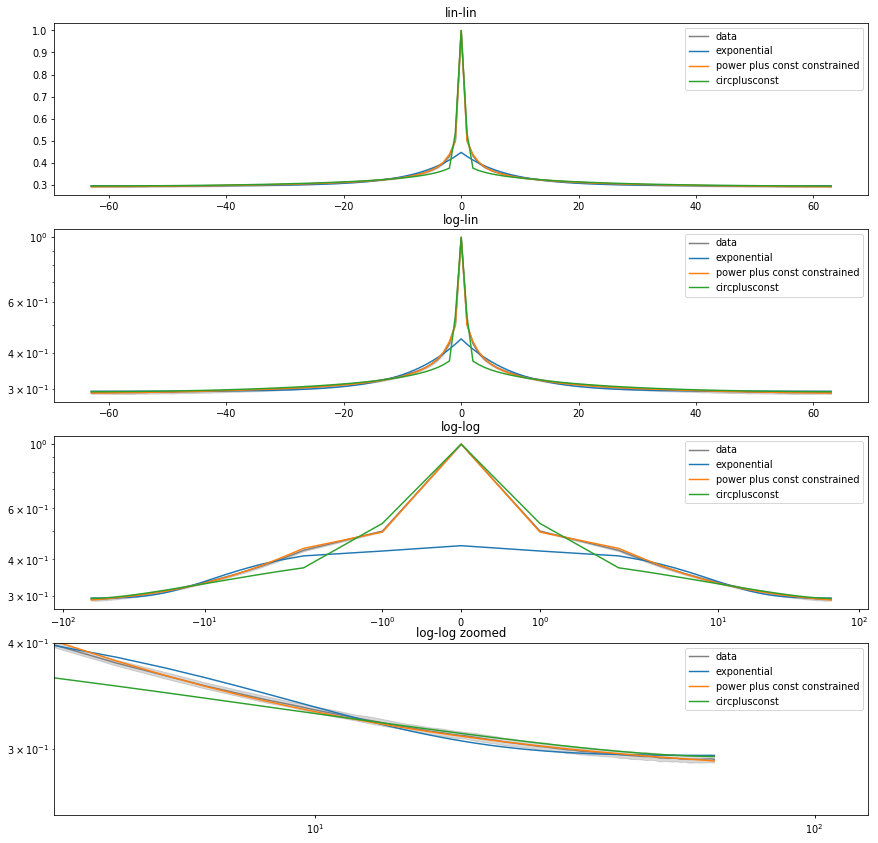

In [35]:
## Looking closely at the MCMC correlation function

from munch import Munch
import scipy

f, axes = plt.subplots(4, figsize = (15,15))

N = 128
state_means = real_data[N].mean(axis=-1)[:, None]
C = np.cov(real_data[N], rowvar = False)
corr_func = diag2column(C).mean(axis = 0)
dcorr_func = diag2column(C).std(axis = 0)

print(f'corr_func[0] = {corr_func[0]}')

corr_func_sym = np.concatenate([corr_func[N//2+1:], corr_func[:N//2]])
dcorr_func_sym = np.concatenate([dcorr_func[N//2+1:], dcorr_func[:N//2]])
sym = np.arange(-N//2+1, N//2)

x = sym
y = corr_func_sym
dy = dcorr_func_sym
    
xrange = (abs(sym) > 1) & (abs(sym) <= N//2)
fits = [
        Munch(name='exponential', f = exponential, p0=[1, 0.3, 2], xrange = xrange),
        Munch(name='power plus const constrained', f = powerconst_contrained, p0=[0.3, 1, 0], xrange = (abs(sym) <= N//2)),
        #Munch(name='power', f = power, p0=[1, 2], xrange = xrange),
        #Munch(name='circpower', f = circpower(N), p0=[1, 2], xrange = (x > 1)),
        Munch(name='circplusconst', f = best(N), p0=[1, 2, 0], xrange = (x > 0)),
        ]
for fit in fits:
    fit.popt, fit.pcov = scipy.optimize.curve_fit(fit.f, x[fit.xrange], y[fit.xrange],
                                              p0=fit.p0, sigma=dy[fit.xrange],
                                              absolute_sigma=True, check_finite=True)
    dp = np.sqrt(np.diag(fit.pcov))
    print(f'{fit.name}, popt = {fit.popt} +/- {dp}')
    

    
for ax in axes:
    spread(ax, sym, corr_func_sym, dcorr_func_sym, color = 'grey', label = 'data')
    
    for fit in fits:
        ax.plot(x, fit.f(x, *fit.popt), label = fit.name)
    
    ax.legend()

axes[0].set(title = 'lin-lin')
axes[1].set(title = 'log-lin', yscale = 'log')
axes[2].set(title = 'log-log', yscale = 'log', xscale = 'symlog');
axes[3].set(title = 'log-log zoomed', yscale = 'log', xscale = 'symlog', xlim = (3, 128), ylim = (0.25,4e-1));

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


powerconst_contrained, popt = [ 1.          0.3        -0.21072368] +/- [71079.22271529 96505.21906883            nan]
powerconst_contrained, popt = [0.21295153 1.68227561 0.48668436] +/- [0.00862254 0.37029184 0.01482736]
powerconst_contrained, popt = [0.25974687 1.057919   0.37623812] +/- [0.00353482 0.069338   0.00564797]
powerconst_contrained, popt = [0.2869629  0.84997764 0.31305317] +/- [0.00263632 0.02987076 0.00317185]
powerconst_contrained, popt = [0.29071959 0.7282825  0.28279533] +/- [0.00267271 0.01887706 0.00196101]
powerconst_contrained, popt = [0.2841472  0.68816278 0.27362543] +/- [0.00232499 0.01235263 0.00109603]


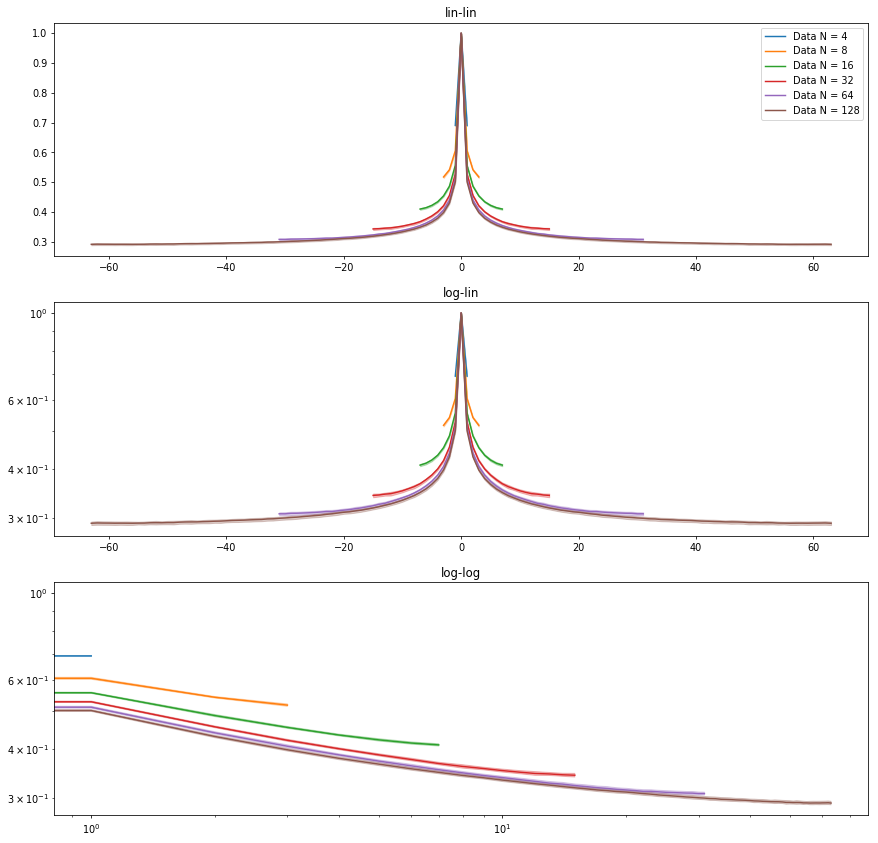

In [36]:
from munch import Munch
from FKMC.general import spread
import scipy
fitN = dict()

f, axes = plt.subplots(3, figsize = (15,15))
#s = obs.state[-3]
for s in obs.state:
    i = np.all(np.isfinite(s), axis = (-2,-1))
    states = s[i, ...]
    states = 2*states - 1

    N = states.shape[-1]
    alternating = 2*(np.arange(N) % 2) - 1
    a_states = states.reshape(-1, N) * alternating

    #calculate the 2d correlation matrix
    state_means = a_states.mean(axis=-1)[:, None]
    C = np.cov(a_states, rowvar = False)

    #calculate the 1d correlation function
    corr_func = diag2column(C).mean(axis = 0)
    dcorr_func = diag2column(C).std(axis = 0)

    corr_func_sym = np.concatenate([corr_func[N//2+1:], corr_func[:N//2]])
    dcorr_func_sym = np.concatenate([dcorr_func[N//2+1:], dcorr_func[:N//2]])
    sym = np.arange(-N//2+1, N//2)

    x = sym
    y = corr_func_sym
    dy = dcorr_func_sym
    
    fits = [
            Munch(name='power plus const constrained', f = powerconst_contrained, p0=[1, 0.3, 2], xrange = (abs(x) <= N//2)),
            #Munch(name='circplusconst', f = best(N), p0=[1, 2, 0], xrange = (x > 0)),
           ]


    for fit in fits:
        try:
            fit.popt, fit.pcov = scipy.optimize.curve_fit(fit.f, x[fit.xrange], y[fit.xrange], p0=fit.p0, sigma=dy[fit.xrange], absolute_sigma=True, check_finite=True)
            dp = np.sqrt(np.diag(fit.pcov))
            print(f'{fit.f.__name__}, popt = {fit.popt} +/- {dp}')
            fit.worked = True
        except TypeError as e:
            print(f'fit failed on N = {N} for fit = {fit.name} with error {e}')
            fit.worked = False
    
    fitN[N] = fits

    B = corr_func[N//2]
    for ax in axes:
        for fit in fits:
            if fit.worked: 
                #ax.plot(x[fit.xrange], fit.f(x[fit.xrange], *fit.popt), '--k', label = fit.f.__name__)
                pass
        #l, = ax.plot(x, corr_func)
        #ax.scatter(x, corr_func, marker ='.', label = 'Data', color = l.get_color())
        spread(ax, x, y, dy, label = f'Data N = {N}')
        #ax.legend()

axes[0].set(title = 'lin-lin')
axes[0].legend()
axes[1].set(title = 'log-lin', yscale = 'log')
axes[2].set(title = 'log-log', yscale = 'log', xscale = 'log');

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


[None, None]

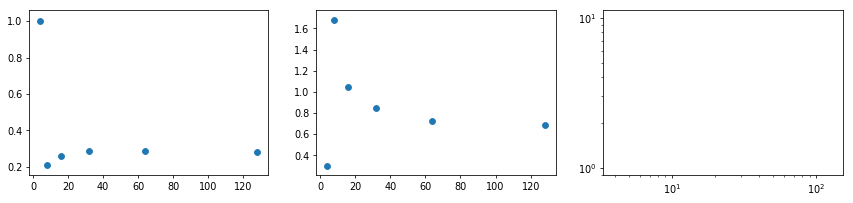

In [13]:
A, gamma, B = np.array([fit[0].popt for fit in fitN.values()]).T

f, axes = plt.subplots(1,3)

axes[0].scatter(obs.Ns, A)
axes[1].scatter(obs.Ns, gamma)
axes[2].scatter(obs.Ns, B)

axes[-1].set(yscale = 'log', xscale = 'log')

## Ok now try generating some noise from the measured data

mean(data) = 0.0016640625
std(data) = 0.9999986154470403
mean(binary) = -0.0032265625
std(binary) = 0.9999947946336692


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/ma/core.py:856: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


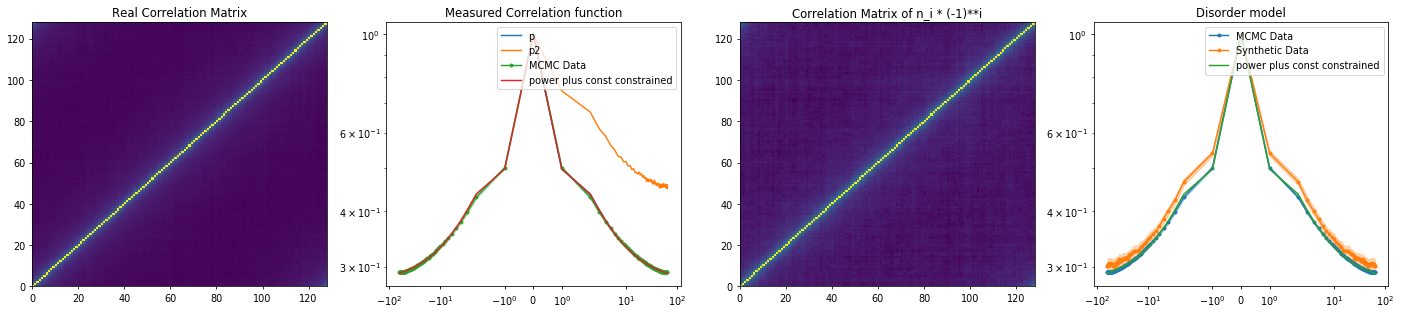

In [37]:
from numpy.fft import rfft, irfft, rfftfreq, hfft, ihfft, fftshift
from disorder_model import correlated_noise
from FKMC.general import diag2column, spread

M = int(1e4) # average over this many replications
N = 128 # system size
    
#Generate some noise to fit
fit = fitN[N][0]
x2 = np.arange(0, N//2 + 1,1)
p = fit.f(x2, *fit.popt) *np.where(x2 == 0, 1, 1)
power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M, scale = 1)
binary = 2*(power_law_noise > 0) - 1

print(f'mean(data) = {real_data[N].mean()}')
print(f'std(data) = {real_data[N].std()}')

print(f'mean(binary) = {binary.mean()}')
print(f'std(binary) = {binary.std()}')

def compute_symmetric_correlation_function(states):
    C = np.cov(states, rowvar = False)
    
    #calculate the 1d correlation function
    corr_func = diag2column(C).mean(axis = 0)
    dcorr_func = diag2column(C).std(axis = 0)
    
    corr_func_sym = np.concatenate([corr_func[N//2+1:], corr_func[:N//2]])
    dcorr_func_sym = np.concatenate([dcorr_func[N//2+1:], dcorr_func[:N//2]])
    sym = np.arange(-N//2+1, N//2)
    return sym, C, corr_func_sym, dcorr_func_sym, corr_func

sym, real_C, real_corr, real_dcorr, nonsym = compute_symmetric_correlation_function(real_data[N])
_, model_C, model_corr, model_dcorr, nonsym_model = compute_symmetric_correlation_function(binary)

p2 = p * (p/nonsym_model[:N//2+1])
power_law_noise, U, Uq, Sq, Nq = correlated_noise(p2, replications = M, scale = 1)
binary = 2*(power_law_noise > 0) - 1
_, model_C, model_corr, model_dcorr, _ = compute_symmetric_correlation_function(binary)

##plot stuff
f, axes = plt.subplots(1,4, figsize = (25,5))   

#plot the covariance matrix of the real data
axes[0].set(title = 'Real Correlation Matrix');
axes[0].pcolormesh(real_C.T)

#collapse the covariance matrix into a correlation function and plot the fit to it
ax = axes[1]
ax.set(title = 'Measured Correlation function', yscale = 'log', xscale = 'symlog');
##plot the data
ax.plot(x2, p, label = 'p')
ax.plot(x2, p2, label = 'p2')

l, fill = spread(ax, sym, real_corr, real_dcorr, marker = '.', label = 'MCMC Data')

for fit in fitN[128]:
    ax.plot(sym, fit.f(sym, *fit.popt), label = fit.name)
ax.legend()


axes[2].set(title = 'Correlation Matrix of n_i * (-1)**i');
axes[2].pcolormesh(model_C.T)

ax = axes[3]
ax.set(title = 'Disorder model', yscale = 'log', xscale = 'symlog');
##plot the model data
l, fill = spread(ax, sym, real_corr, real_dcorr, marker = '.', label = 'MCMC Data')
l, fill = spread(ax, sym, model_corr, model_dcorr, marker = '.', label = 'Synthetic Data')


##plot the fits
for fit in fitN[128]:
    ax.plot(sym, fit.f(sym, *fit.popt), label = fit.name)

ax.legend()

## Now use that noise to look at some observables

In [15]:
obs.Mf_moments.shape, obs.Mf_moments_shapehint

((6, 100, 5, 1000), ('Ns', 'repeats', 'moment', 'MCstep'))

using parameters from power plus const constrained p0 = [0.2841472  0.68816278 0.27362543]


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/ma/core.py:856: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/tch14/FKMC/notebooks/munich/disorder_model.py:16: RuntimeWarning: invalid value encountered in sqrt
  Nq = np.sqrt(Sq) * Uq
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


Done


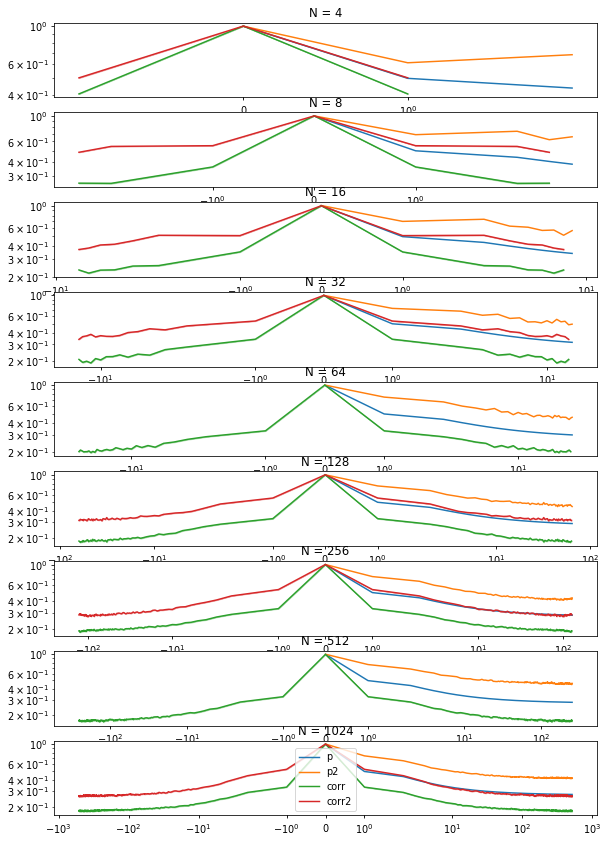

In [38]:
#generate noise for the same system sizes as the MCMC data
M = int(500) # average over this many replications, equivalent of monte carlo steps

fit = fitN[128][0]
print(f'using parameters from {fit.name} p0 = {fit.popt}')

Ns = [4,8,16,32,64,128,256,512,1024]
f, axes = plt.subplots(len(Ns),1, figsize = (10,15))

disorder_model = dict()

for ax, N in zip(axes, Ns):    
    x = np.arange(0, N//2 + 1, 1) #range for the correlation function
    p = fit.f(x, *fit.popt) * np.where(x == 0, 1, 1) # the desired correlation function
    power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M, scale = 1)
    binary_noise = 2*(power_law_noise > 0) - 1
    
    sym, C, corr, dcorr, nonsym = compute_symmetric_correlation_function(binary_noise)
    
    #the correction step
    p2 = p**2 / nonsym[:N//2 + 1]
    power_law_noise, U, Uq, Sq, Nq = correlated_noise(p2, replications = M)
    binary_noise = 2*(power_law_noise > 0) - 1
    
    _, C2, corr2, dcorr2, _ = compute_symmetric_correlation_function(binary_noise)
    
    ax.plot(x, p, label = 'p')
    ax.plot(x, p2, label = 'p2')
    spread(ax, sym, corr, dcorr/np.sqrt(M), label = 'corr')
    spread(ax, sym, corr2, dcorr2/np.sqrt(M), label = 'corr2')
    ax.set(xscale = 'symlog', yscale = 'log', title = f'N = {N}')
    
    #put it into AFM [0,1] form if necessary 
    #alternating = 2*(np.arange(binary_noise.shape[-1]) % 2) - 1
    #alternating_binary_noise = binary_noise * alternating
    #states = alternating_binary_noise/2 + 1 #shift the -1,1 values up to 0,1
    
    disorder_model[N] = binary_noise
    
ax.legend()
print('Done')

## Plotting the correlation functions for diffferent N

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/ma/core.py:6666: RuntimeWarning: underflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/ma/core.py:856: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


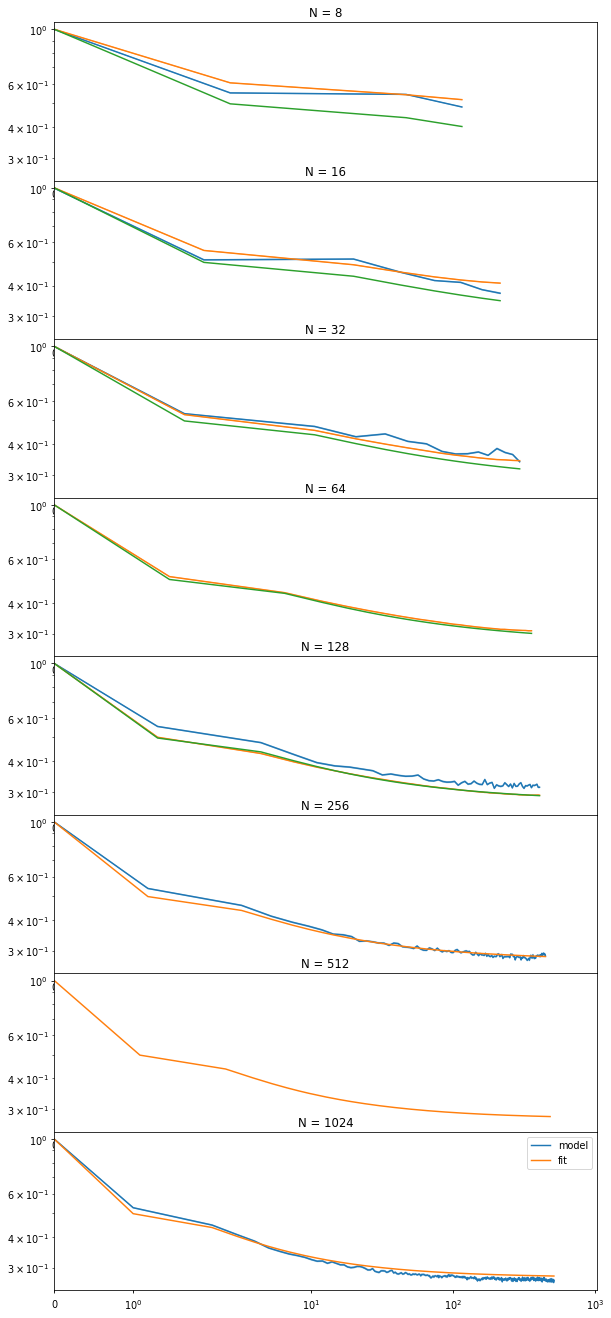

In [39]:
from itertools import count
Ns = [8, 16, 32, 64, 128,256, 512, 1024]
f, axes = plt.subplots(len(Ns),1, sharey = 'all', figsize =(10, 3*len(Ns)), gridspec_kw = dict(hspace = 0))

for i, N, ax in zip(count(), Ns, axes):
    ax.set(title = f'N = {N}')

    #disorder model
    if N in disorder_model:
        sym, C, corr_func, dcorr_func, _ = compute_symmetric_correlation_function(disorder_model[N])
        #ax.plot(sym, corr_func, label = 'model')
        spread(ax, sym, corr_func, dcorr_func/np.sqrt(M), label = 'model')
    
    #data
    if N in real_data:
        sym, C, corr_func, dcorr_func, _ = compute_symmetric_correlation_function(real_data[N])
        #ax.plot(sym, corr_func, label = 'data')
        spread(ax, sym, corr_func, dcorr_func/np.sqrt(M), label = 'data')
    
    #fit
    p = fitN[128][0].f(sym, *fit.popt)
    ax.plot(sym, p, label = 'fit')
    

    ax.set(yscale = 'log', xscale = 'symlog', xlim = (0, N))
    
ax.legend()
    

## Comparing histograms of energy between the disorder model and the MCMC

In [42]:
from time import time
from munch import Munch
from FKMC.general import interaction_matrix, solve_H_vectorised, index_histogram_array, sort_IPRs, smooth
from FKMC.stats import correlated_noise

disorder_model_solutions = dict()
params = Munch(obs.parameters)
print(params)

def compute_histograms(E_bins, evals, evecs):
    IPRs = ((evecs * np.conj(evecs))**2).sum(axis = -2)
    
    evals = evals.reshape(-1, evals.shape[-1])
    IPRs = IPRs.reshape(-1, evals.shape[-1])
    
    E_hist, _, indices = index_histogram_array(E_bins, evals)
    IPR_hist = sort_IPRs(indices, IPRs, E_bins)
    
    IPR_hist = IPR_hist.mean(axis = 0)
    E_hist = E_hist.mean(axis = 0)
    E_hist = E_hist/E_hist.sum()
    
    E = np.where(E_hist == 0, 1, E_hist)
    I = np.where(E_hist > 0, IPR_hist/E, 0)
    
    return E_hist, I

for N, states in disorder_model.items():
    if N > 1024: continue
    print(f'N = {N}', end='')
    
    M = Munch()
    disorder_model_solutions[N] = M
    
    params.N = N
    params.J_matrix = interaction_matrix(**params)
    
    print(f', Diagonalising hamiltonians', end='')
    t0 = time()
    s = (states + 1)/2
    M.Ff, M.Fc, M.evals, evecs = solve_H_vectorised(s, **params)
    print(f' ({time()-t0:.0f}s)', end='')
    
    print(f', Computing IPR histograms', end='')
    t0 = time()
    M.E_bins = np.linspace(-10, 10, 500 + 1)
    M.E_hist, M.IPR_hist = compute_histograms(M.E_bins, M.evals, evecs)
    print(f' ({time()-t0:.0f}s)')
    

Munch({'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.6666666666666666, 'J': 5, 'U': 5, 'normalise': True, 'J_matrix': '...'})
N = 4, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 8, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 16, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 32, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 64, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 128, Diagonalising hamiltonians (1s), Computing IPR histograms (0s)
N = 256, Diagonalising hamiltonians

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


 (2s), Computing IPR histograms

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


 (0s)
N = 512, Diagonalising hamiltonians (10s), Computing IPR histograms (1s)
N = 1024, Diagonalising hamiltonians (85s), Computing IPR histograms (3s)


In [50]:
def compute_solutions(Ns, states, Ebins = np.linspace(-5, 5, 700 + 1)):
    'states be a list of np arrays with shape [repeats, N] one for each N in Ns, states should be in FM [-1,1] convention'
    solutions = {}
    for N, state in zip(Ns, states):
        print(f'N = {N}', end='')

        M = Munch()
        solutions[N] = M

        params.N = N
        params.J_matrix = interaction_matrix(**params)

        print(f', Diagonalising hamiltonians', end='')
        t0 = time()
        
        assert(((state == -1) | (state == 1)).all())
        A = (2*(np.arange(N) % 2) - 1)[None, :]
        AFM_state = ((state * A)+1)/2
        
        M.Ff, M.Fc, M.evals, evecs = solve_H_vectorised(AFM_state, **params)


        powers = np.arange(6)
        M.Mf_moments = np.sum(state/N, axis = -1)[None, :]**powers[:, None]

        print(f' ({time()-t0:.0f}s)', end='')

        print(f', Computing IPR histograms', end='')
        t0 = time()
        M.E_bins = Ebins
        M.E_hist, M.IPR_hist = compute_histograms(M.E_bins, M.evals, evecs)
        print(f' ({time()-t0:.0f}s)')
        
    return solutions

def plot_IPR_scaling(Ns, solutions):
    
    f, ((Eax,zEax,ax2),(Iax,zIax,ax3)) = plt.subplots(2,3, figsize = (20,5), gridspec_kw = dict(width_ratios = [3,2,1]))

    for N in Ns:
        s = solutions[N]

        sI = smooth(s.IPR_hist, scale = 50/N, axis = -1)
        sE = smooth(s.E_hist, scale = 50/N, axis = -1)

        Eax.plot(s.E_bins[:-1], sE);
        Iax.plot(s.E_bins[:-1], sI/N, label = f'N = {N}');
        zEax.plot(s.E_bins[:-1], sE);
        zIax.plot(s.E_bins[:-1], sI/N, label = f'N = {N}');
        
        for a in [zEax, zIax]: a.set(xlim = (2,4))

    for i in [1,2,4]:
        ax2.plot(Ns, [solutions[N].Mf_moments[i].mean(axis = -1) for N in Ns], marker = 'o', label = f'M^{i}')

    Iax.legend()
    ax2.legend()
    
    return f, ((Eax,zEax,ax2),(Iax,zIax,ax3))

## Test with no CDW and some disorder

N = 32, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 64, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 80, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 128, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 256, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 512, Diagonalising hamiltonians

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


 (0s), Computing IPR histograms (0s)


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


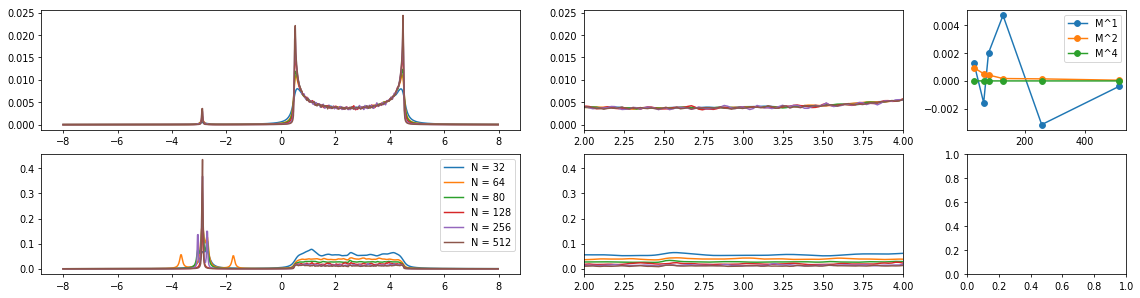

In [54]:
Ns = [32,64,80,128,256,512]
Ms = [100, 100, 50, 10, 10, 10]

p = 0.01
states = [(2*(np.arange(N)%2) - 1)[None, :] * np.random.choice([-1,1], p = [p,1-p], size = (M, N)) for M,N in zip(Ms,Ns)]
solns = compute_solutions(Ns, states, Ebins = np.linspace(-8, 8, 700 + 1))
f, ((Eax,zEax,ax2),(Iax,zIax,ax3)) = plot_IPR_scaling(Ns, solns)

## Test with a perfectly ordered CDW state

N = 32, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 64, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 80, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 128, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 256, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 512, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)


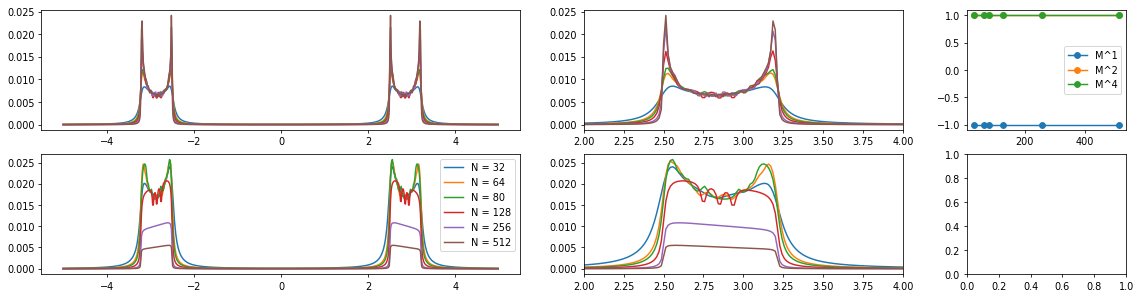

In [204]:
Ns = [32,64,80,128,256,512]
perfect_AFM_states = [-np.ones(N)[None, :] for N in Ns]
perfect_AFM = compute_solutions(Ns, perfect_AFM_states)
f, ((Eax,zEax,ax2),(Iax,zIax,ax3)) = plot_IPR_scaling(Ns, perfect_AFM)

## Add some uncorrelated perturbations to the CDW state

N = 64, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 80, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 128, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 256, Diagonalising hamiltonians

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


 (0s), Computing IPR histograms (0s)
N = 512, Diagonalising hamiltonians

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


 (0s), Computing IPR histograms (0s)
N = 1024, Diagonalising hamiltonians (1s), Computing IPR histograms (0s)
N = 2048, Diagonalising hamiltonians (5s), Computing IPR histograms (0s)


(<Figure size 1400x350 with 6 Axes>,
 ((<matplotlib.axes._subplots.AxesSubplot at 0x7f0734ad0710>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f0734617080>),
  (<matplotlib.axes._subplots.AxesSubplot at 0x7f073543add8>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f07346ac780>)))

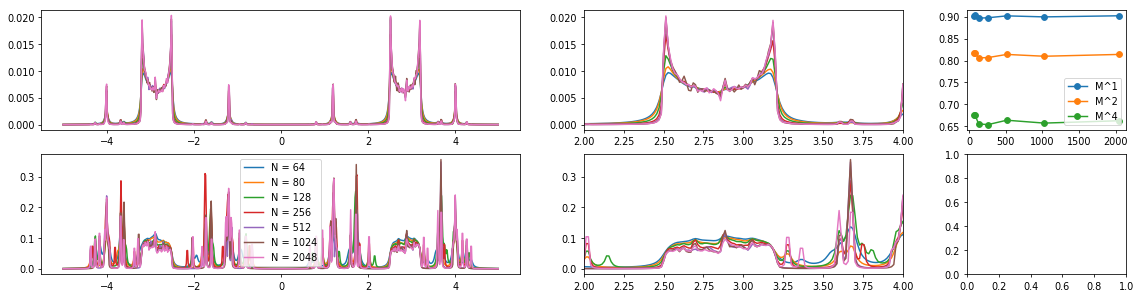

In [205]:
Ns = [64,80,128,256,512,1024,2048] #system sizes
Ms = [100,100,100,50, 10, 5, 5] #how many averages to do for each system size

p = 0.05
imperfect_AFM_states = [np.random.choice([-1,1], p = [p,1-p], size = (M, N)) for M,N in zip(Ms,Ns)]
imperfect_AFM = compute_solutions(Ns, imperfect_AFM_states)
plot_IPR_scaling(Ns, imperfect_AFM)

0.0
0.0


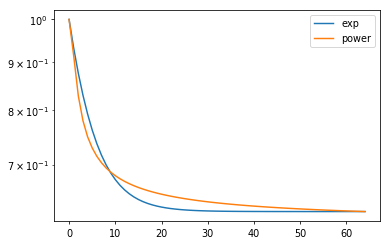

In [96]:
def expcorr(x, l, m, N):
    #evaluate the sum from n = 0 to N-1 of e**(-n/l) = (x^N - 1)/(x - 1) where x = -1/l
    s = np.expm1(-N/l) / np.expm1(-1/l)
    a = (N*m**2 - s)/(N - s)
    f = (1 - a)*np.exp(-x/l) + a
    
    return f

def powercorr(x, alpha, m, N):
    def f(n): return ((1 + n**2)**(-alpha/2))
    
    n = np.arange(N)
    s = f(n).sum()
    a = (N*m**2 - s)/(N - s)
    f = (1 - a)*f(x) + a
    
    return f

N = 128
x = np.arange(0, N//2 + 1, 1)
l = 5
m = 0.8

f, ax = my_subplots()
ax.set(yscale = 'log', xscale = 'linear')

f = expcorr(x, l, m, N)
ax.plot(x, f, label = 'exp')

f = powercorr(x, 0.7, m, N)
ax.plot(x, f, label = 'power')

ax.legend()

n = np.arange(N)
print(expcorr(n, l, m, N).sum() - N*m**2)
print(powercorr(n, l, m, N).sum() - N*m**2)

#y = expcorr(x, l, m, N)
#print(y.sum() / N)


0.9944171979980468


[None]

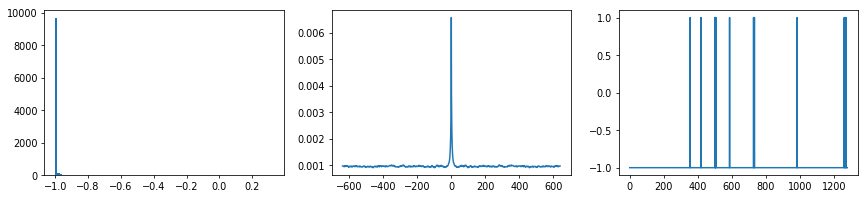

In [151]:
N = 1280
x = np.arange(0, N//2 + 1, 1)
l = 5
m = 0.9
M = 10000


p =  expcorr(x, l = l, m = 0.8, N = N)# the desired correlation function
power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M)
binary_noise = 2*((power_law_noise - 3) > 0) - 1

noise = power_law_noise
noise = binary_noise

sym, C, corr, dcorr, nonsym = compute_symmetric_correlation_function(noise)

m = (noise.mean(axis = -1) ** 2).mean(axis = -1)
print(m)

f, (ax1,ax2,ax3) = my_subplots(1,3)
ax3.plot(noise[0])
ax2.plot(sym, corr)
ax1.hist(noise.mean(axis = -1), bins = 100)
ax.set(yscale = 'linear')

/home/tch14/FKMC/notebooks/munich/disorder_model.py:16: RuntimeWarning: invalid value encountered in sqrt
  Nq = np.sqrt(Sq) * Uq
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


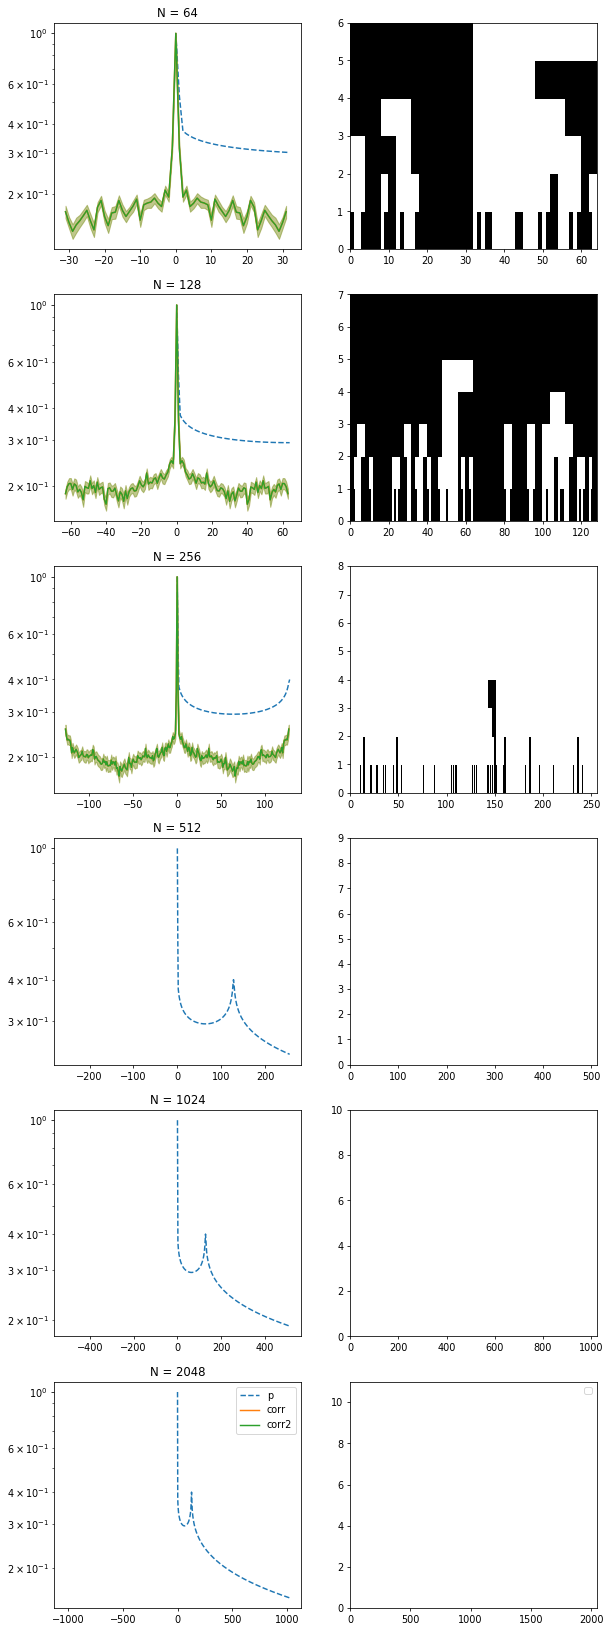

In [18]:
from disorder_model import correlated_noise

Ns = [64,128,256,512,1024,2048] #system sizes
Ms = [100,100,100,50, 10, 10, 10]

def expcorr(x, l): return(1 - m**2)*np.exp(-x/l) + m**2
l = 10
msquared = 0.9

correlated_noise_model = []

f, axes = plt.subplots(len(Ns),2, figsize = (10,30))
for (ax,ax2), M, N in zip(axes, Ms, Ns):    
    x = np.arange(0, N//2 + 1, 1) #range for the correlation function
    
    p = fit.f(x, *fit.popt) * np.where(x == 0, 1, 1) # the desired correlation function
    
    #p = p - p.mean() + msquared
    
    power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M, scale = 1)
    binary_noise = 2*(power_law_noise > 0) - 1
    
    sym, C, corr, dcorr, nonsym = compute_symmetric_correlation_function(binary_noise)
    
    #the correction step
    #p2 = p**2 / nonsym[:N//2 + 1]
    #power_law_noise, U, Uq, Sq, Nq = correlated_noise(p2, replications = M)
    #binary_noise = 2*(power_law_noise > 0) - 1
    
    _, C2, corr2, dcorr2, _ = compute_symmetric_correlation_function(binary_noise)
    
    ax.plot(x, p, '--', label = 'p')
    #ax.plot(x, p2, label = 'p2')
    spread(ax, sym, corr, dcorr/np.sqrt(M), label = 'corr')
    spread(ax, sym, corr2, dcorr2/np.sqrt(M), label = 'corr2')
    ax.set(xscale = 'linear', yscale = 'log', title = f'N = {N}')
    
    correlated_noise_model.append(binary_noise)
    
    #plot a real space RG like smoothing flow for the state
    state = binary_noise[-1]
    for i in range(int(np.log(N)/np.log(2))):
        s = 2**i
        resampled_x = np.arange(0,N+s,s)
        smoothed_state = np.round(state.reshape(-1,s).mean(axis = -1)/2 + 1/2)
        ax2.pcolormesh(resampled_x, [i,i+1], np.array([smoothed_state,smoothed_state]), cmap = 'Greys', vmin = 0, vmax = 1)
        
        
ax2.legend()
ax.legend()

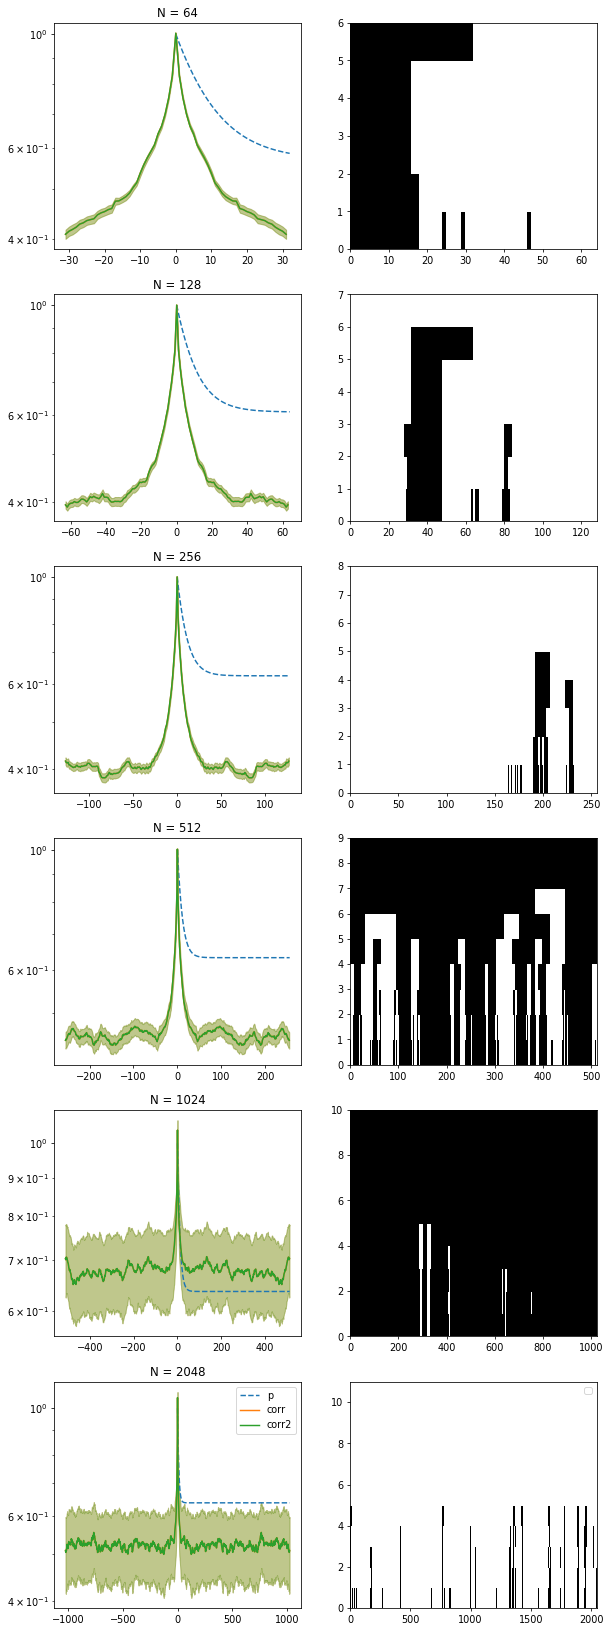

In [98]:
from disorder_model import correlated_noise

Ns = [64,128,256,512,1024,2048] #system sizes
Ms = [100,100,100,50, 10, 10, 10]
l = 10

correlated_noise_model = []

f, axes = plt.subplots(len(Ns),2, figsize = (10,30))
for (ax,ax2), M, N in zip(axes, Ms, Ns):    
    x = np.arange(0, N//2 + 1, 1) #range for the correlation function
    
    p =  expcorr(x, l = l, m = 0.8, N = N)# the desired correlation function
    power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M, scale = 1)
    binary_noise = 2*(power_law_noise > 0) - 1
    
    sym, C, corr, dcorr, nonsym = compute_symmetric_correlation_function(binary_noise)
    
    #the correction step
    #p2 = p**2 / nonsym[:N//2 + 1]
    #power_law_noise, U, Uq, Sq, Nq = correlated_noise(p2, replications = M)
    #binary_noise = 2*(power_law_noise > 0) - 1
    
    _, C2, corr2, dcorr2, _ = compute_symmetric_correlation_function(binary_noise)
    
    ax.plot(x, p, '--', label = 'p')
    #ax.plot(x, p2, label = 'p2')
    spread(ax, sym, corr, dcorr/np.sqrt(M), label = 'corr')
    spread(ax, sym, corr2, dcorr2/np.sqrt(M), label = 'corr2')
    ax.set(xscale = 'linear', yscale = 'log', title = f'N = {N}')
    
    correlated_noise_model.append(binary_noise)
    
    #plot a real space RG like smoothing flow for the state
    state = binary_noise[-1]
    for i in range(int(np.log(N)/np.log(2))):
        s = 2**i
        resampled_x = np.arange(0,N+s,s)
        smoothed_state = np.round(state.reshape(-1,s).mean(axis = -1)/2 + 1/2)
        ax2.pcolormesh(resampled_x, [i,i+1], np.array([smoothed_state,smoothed_state]), cmap = 'Greys', vmin = 0, vmax = 1)     
        
ax2.legend()
ax.legend()

N = 64, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 80, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 128, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in square
  # This is added back by InteractiveShellApp.init_path()



N = 256, Diagonalising hamiltonians (0s), Computing IPR histograms (0s)
N = 512, Diagonalising hamiltonians

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


 (0s), Computing IPR histograms (0s)
N = 1024, Diagonalising hamiltonians (1s), Computing IPR histograms (0s)
N = 2048, Diagonalising hamiltonians (10s), Computing IPR histograms (0s)


(<Figure size 1400x350 with 6 Axes>,
 ((<matplotlib.axes._subplots.AxesSubplot at 0x7f07050c57b8>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f0705071940>),
  (<matplotlib.axes._subplots.AxesSubplot at 0x7f0705016eb8>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f0704fe89e8>)))

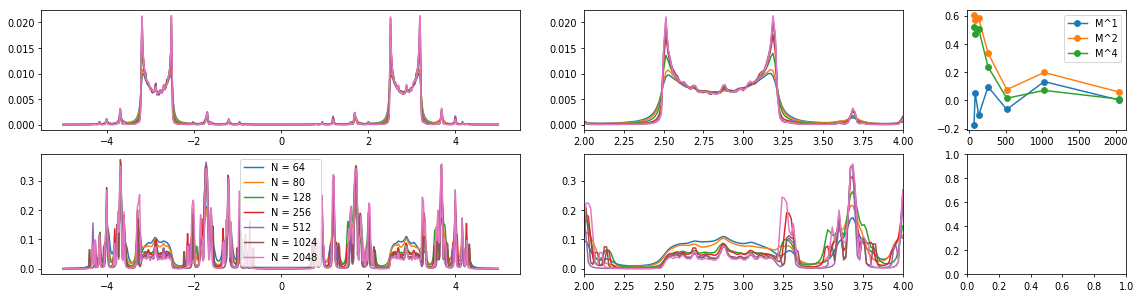

In [224]:
correlated_noise_model_solutions = compute_solutions(Ns, correlated_noise_model)
plot_IPR_scaling(Ns, correlated_noise_model_solutions)

In [61]:
obs.Mf_moments_shapehint

('Ns', 'repeats', 'moment', 'MCstep')

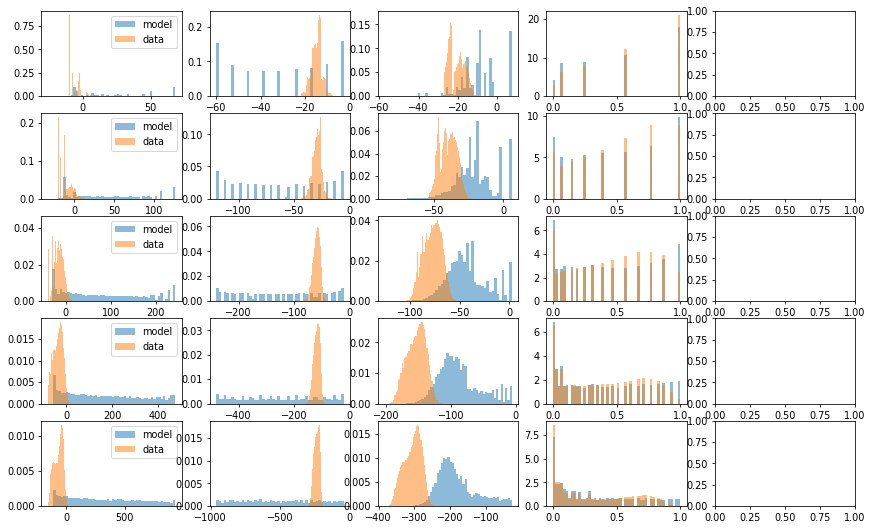

In [64]:
Ns = [8,16,32,64,128]

real_data_N_to_i = {N : i for N,i in zip(obs.Ns, count())}

f, axes = my_subplots(len(Ns), 5)
for N, axes in zip(Ns, axes):
    dm_states = disorder_model[N]
    dm_solns = disorder_model_solutions[N]
    
    i = real_data_N_to_i[N]
    s = obs.state[i]
    j = np.all(np.isfinite(s), axis = (-2,-1))
    
    hist_args = dict(bins = 50, alpha = 0.5, density = 1)
    axes[0].hist(dm_solns.Ff, label = 'model', **hist_args)
    axes[0].hist(obs.Ff[i,j].flatten(), label = 'data', **hist_args)
    
    axes[1].hist(dm_solns.Fc, label = 'model', **hist_args)
    axes[1].hist(obs.Fc[i,j].flatten(), label = 'data', **hist_args)
    
    axes[2].hist(dm_solns.Ff + dm_solns.Fc, label = 'model', **hist_args)
    axes[2].hist(obs.Ff[i,j].flatten() + obs.Fc[i,j].flatten(), label = 'data', **hist_args)
    
    N_cumulants = 6
    powers = np.arange(N_cumulants)
    Mf_moments = np.sum(disorder_model[N] / N, axis = -1)[None, :]**powers[:, None]
    Mf_means = Mf_moments.mean(axis = -1)
    dMf_means = Mf_moments.std(axis = -1)
    
    axes[3].hist(Mf_moments[2], label = 'model', **hist_args)
    axes[3].hist(obs.Mf_moments[i, j, 2, :].flatten(), label = 'data', **hist_args)
    
    
    
    axes[0].legend()

## Looking at the magnetisations of the disorder model
see that formula I derived

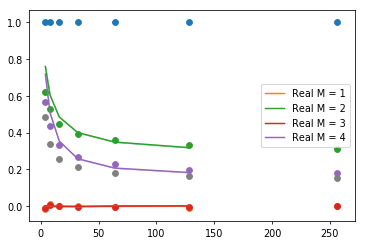

In [75]:
M = int(1e4) # average over this many replications
x2 = np.arange(0, N//2 + 1,1)
fit = fitN[128][0]
p = fit.f(x2, *fit.popt)

M = np.nanmean(obs.Mf_moments, axis = (1,-1))
dM = np.nanstd(obs.Mf_moments, axis = (1,-1)) / np.sqrt(np.sum(np.isfinite(obs.Mf_moments), axis = (1,-1)))

f, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(1,5):
    #ax.plot(obs.Ns, M[:, i], label = f'M = {i}')
    spread(ax, obs.Ns, M[:, i], dM[:, i], label = f'Real M = {i}', color = colors[i])

Ns = [4,8,16,32,64,128,256]
for N in tuple(Ns):
    
    N_cumulants = 6
    powers = np.arange(N_cumulants)
    Mf_moments = np.sum(disorder_model[N] / N, axis = -1)[None, :]**powers[:, None]
    Mf_means = Mf_moments.mean(axis = -1)
    dMf_means = Mf_moments.std(axis = -1)

    for i in range(5):
        ax.scatter((N,), Mf_means[i], color = colors[i])
        
    x2 = np.arange(0, N//2 + 1,1)
    fit = fitN[128][0]
    p = fit.f(x2, *fit.popt)
    ax.scatter((N,), np.sum(p)/N, color = 'grey')
    
ax.legend()

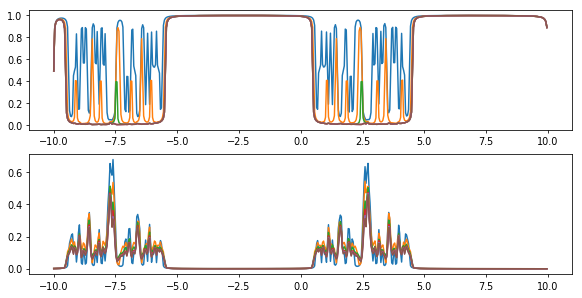

In [82]:
from munch import Munch
from FKMC.general import interaction_matrix, solve_H_vectorised, index_histogram_array, sort_IPRs, smooth
from FKMC.stats import correlated_noise



def compute_histograms(E_bins, evals, IPRs):
    evals = evals.reshape(-1, evals.shape[-1])
    IPRs = IPRs.reshape(-1, evals.shape[-1])
    
    E_hist, _, indices = index_histogram_array(E_bins, evals)
    IPR_hist = sort_IPRs(indices, IPRs, E_bins)
    
    IPR_hist = IPR_hist.mean(axis = 0)
    E_hist = E_hist.mean(axis = 0)
    E_hist = E_hist/E_hist.sum()
    
    E = np.where(E_hist == 0, 1, E_hist)
    I_hist = np.where(E_hist > 0, IPR_hist/E, np.nan)
    
    return E_hist, I_hist
    
f, ax = plt.subplots(2, figsize = (10,5))
for N in [8,16,32,64,128,256]:
    dm_solns = disorder_model_solutions[N]
    
    sI = smooth(dm_solns.IPR_hist, scale = 0.1, axis = -1)
    sE = smooth(dm_solns.E_hist, scale = 0.1, axis = -1)


    ax[0].plot(dm_solns.E_bins[:-1], sE);
    ax[1].plot(dm_solns.E_bins[:-1], sI/N);

In [ ]:
from itertools import count
f, ax = plt.subplots(2,1, figsize = (20,5))

for i, N in zip(count(), obs.Ns):
    E_vals = obs.eigenvals[i]
    IPRs = obs.IPRs[i]
    shapes(IPRs)
    
    E_bins = np.linspace(-6, 6, 500 + 1)
    E_hist, _, indices = index_histogram_array(E_bins, E_vals)
    IPR_hist = sort_IPRs(indices, IPRs, E_bins)

    E_hist = E_hist.mean(axis = (0,1))
    IPR_hist = IPR_hist.mean(axis = (0,1))
    
    E = np.where(E_hist == 0, 1, E_hist)
    I = np.where(E_hist > 0, IPR_hist/E, 0)
    sI = smooth(I, scale = 1, axis = -1)
    sE = smooth(E_hist, scale = 1, axis = -1)
    
    l, = ax[0].plot(E_bins[:-1], sE, label = f'N = {N}')
    l, = ax[1].plot(E_bins[:-1], sI/N)
    
ax[0].legend()

In [210]:
from scipy.special import comb as nCr

samples = int(1e5)
p = 1 #probability of croaking
sex_assignments = np.random.choice((0,1), size = (samples, 3)) #choose sex assignments for 3 frogs uniformly
croaks = np.random.choice((0,1), p = (1-p,p), size = (samples, 3)) * sex_assignments #allow male frogs to croak with probability p

at_least_one_male = croaks[np.any(sex_assignments == 1, axis = -1)]
at_least_one_croaked = croaks[np.any(croaks == 1, axis = -1)]


print(f'Of {samples} samples, {len(at_least_one_male)/samples*100:.2f}% contain at least one male, expect about {(1 - (0.5)**3)*100:.2f}')
print(f'{len(at_least_one_croaked)/samples*100:.2f}% contain at least one male who croaked, expect {sum(nCr(3,n)*(1 - (1-p)**n) for n in (0,1,2,3))/2**3 *100:.2f}')

which_one_croaked_first = np.array([np.random.choice(*np.where(s == 1)) for s in at_least_one_croaked])

croaked_behind = at_least_one_croaked[which_one_croaked_first > 0] # let frogs 1 and 2 be behind and frog 0 is in front

mm_behind = sum(croaked_behind[:, 1:].sum(axis = -1) == 2) / len(croaked_behind)
mm_behind

Of 100000 samples, 87.58% contain at least one male, expect about 87.50
87.58% contain at least one male who croaked, expect 87.50


0.3575420910057264